# Домашнее задание №1 Tinkoff_DL

### 1. Получить точность 97.5% на MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
#     dataset = datasets.MNIST('mnist', train=train, download=True, transform=transforms.ToTensor())
    dataset = datasets.MNIST('mnist', train=train, transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

C:\Anaconda\envs\evn_1\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    # nn.Dropout(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32,10),
    nn.LogSoftmax(dim=1)
)

In [11]:
model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=10, bias=True)
  (9): LogSoftmax(dim=1)
)

In [12]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()

Epoch № 0  Score on train set: 0.9562  Score on valid set: 0.9509
Epoch № 1  Score on train set: 0.97  Score on valid set: 0.9626
Epoch № 2  Score on train set: 0.9738  Score on valid set: 0.9668
Epoch № 3  Score on train set: 0.9687  Score on valid set: 0.963
Epoch № 4  Score on train set: 0.9682  Score on valid set: 0.9619
Epoch № 5  Score on train set: 0.9729  Score on valid set: 0.9617
Epoch № 6  Score on train set: 0.9755  Score on valid set: 0.966
Epoch № 7  Score on train set: 0.9832  Score on valid set: 0.9705
Epoch № 8  Score on train set: 0.9798  Score on valid set: 0.9677
Epoch № 9  Score on train set: 0.9791  Score on valid set: 0.9681
Epoch № 10  Score on train set: 0.9853  Score on valid set: 0.9721
Epoch № 11  Score on train set: 0.9817  Score on valid set: 0.9698
Epoch № 12  Score on train set: 0.985  Score on valid set: 0.9751
Epoch № 13  Score on train set: 0.983  Score on valid set: 0.9703
Epoch № 14  Score on train set: 0.9798  Score on valid set: 0.9655
Epoch № 15 

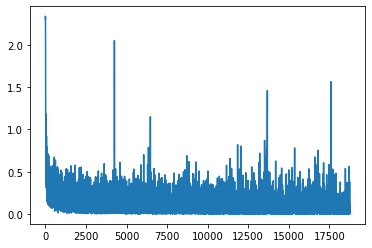

In [14]:
train_losses = []
for epoch in range(20):
    for X, y in train:
        X = X.view(-1, 784)  # разгладим картинку в вектор
        
        optimizer.zero_grad()
        
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        
        train_losses.append(loss.item())
        # как думаете, зачем нужен .item()?
        # подсказка: лосс хранит информацию о своей истории
        # попробуйте убрать .item() и посмотреть на расход памяти
        
        optimizer.step()
    
    print("Epoch №",epoch, " Score on train set:", round(accuracy(model, train), 4),
          " Score on valid set:", accuracy(model, val))
        
plt.plot(train_losses)
plt.show()

In [15]:
# Результат на валидации
print(f'val result: {accuracy(model, val)}')

val result: 0.9751


### 2. Реализовать морфинг автоэнкодером

In [16]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 100)
        )
        
        self.decode = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
            # картинки -- это тензоры со значениями от 0 до 1
            # нет особого смысла выводить что-то не из этого промежутка
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [17]:
model_1 = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters())

In [18]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        #     ^ лэйблы нам не нужны
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model_1(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0394
epoch 1, loss 0.0176
epoch 2, loss 0.0129
epoch 3, loss 0.0106
epoch 4, loss 0.0093
epoch 5, loss 0.0084
epoch 6, loss 0.0077
epoch 7, loss 0.0072
epoch 8, loss 0.0068
epoch 9, loss 0.0064


In [36]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import numpy
import pandas as pd

In [30]:
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model_1.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model_1.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

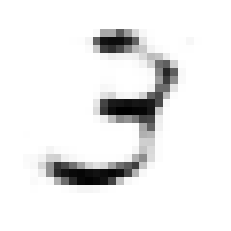

In [31]:
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 30)

### 3. Визуализировать MNIST автоэнкодером

In [45]:
import seaborn as sns

In [32]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )
        
        self.decode = nn.Sequential(
            # а теперь наоборот - из Х-мерного в картинку
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
            # картинки -- это тензоры со значениями от 0 до 1
            # нет особого смысла выводить что-то не из этого промежутка
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [33]:
model_2 = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters())

In [34]:
for epoch in range(20):
    train_loss = 0
    for data, _ in train:
        #     ^ лэйблы нам не нужны
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model_2(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0603
epoch 1, loss 0.0486
epoch 2, loss 0.0454
epoch 3, loss 0.0437
epoch 4, loss 0.0425
epoch 5, loss 0.0416
epoch 6, loss 0.0411
epoch 7, loss 0.0405
epoch 8, loss 0.0402
epoch 9, loss 0.0399
epoch 10, loss 0.0395
epoch 11, loss 0.0392
epoch 12, loss 0.0390
epoch 13, loss 0.0388
epoch 14, loss 0.0386
epoch 15, loss 0.0384
epoch 16, loss 0.0383
epoch 17, loss 0.0382
epoch 18, loss 0.0381
epoch 19, loss 0.0379


In [38]:
df = pd.DataFrame(columns=['x', 'y', 'target'])
for data, y in train:
    data = data.view(-1, 784)
    s = model_2.encode(data)
    b = {'x': s.T[0].tolist(), 'y': s.T[1].tolist(), 'target': y.tolist()}
    df_b = pd.DataFrame(b)
    df = pd.concat([df, df_b])

In [39]:
df.head(3)

,x,y,target
0,-7.490127,-10.555760,8
1,1.025772,-12.278542,2
2,4.466146,7.703550,3


<AxesSubplot:xlabel='x', ylabel='y'>

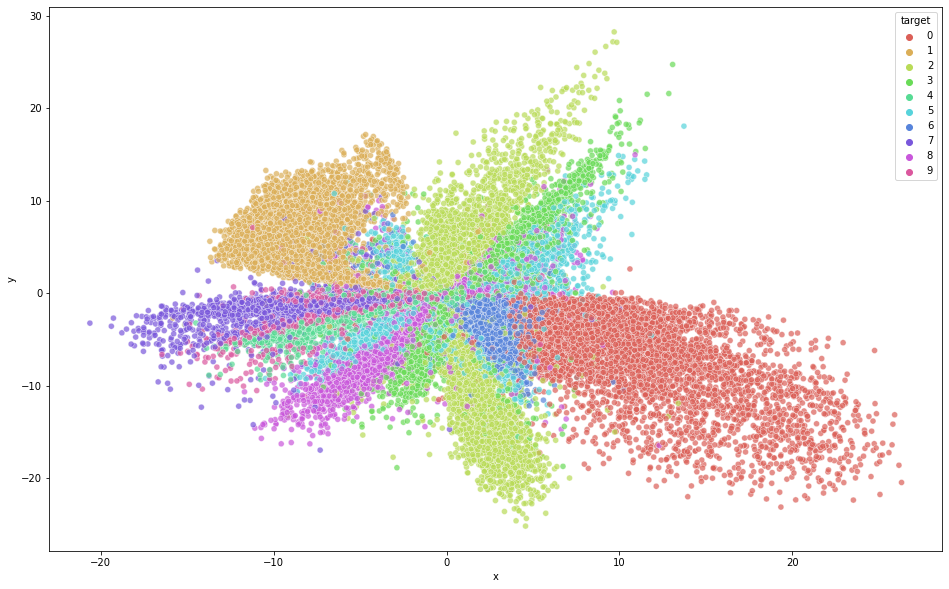

In [46]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="target",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.7
)

In [47]:
# pip install seaborn

#### Посмотрим на работу автоэнкодера: восстановление информации после сжатия

In [48]:
x, y = next(iter(train))

Картинка до сжатия

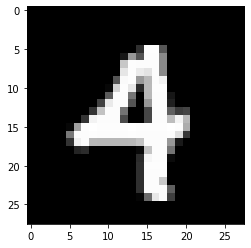

In [49]:
first_image = numpy.array(x[0][0].tolist(), dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

Картинка после работы автоэнкодера

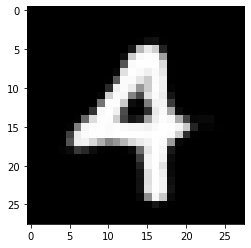

In [52]:
first_image_de = numpy.array(model_1(x[0][0].view(1,784)).tolist(), dtype='float')
pixels = first_image_de.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()